# 1. Introduction & Problem Description


The problem:
We have a large dataset of fish images categorized by species. Our goal is to build a deep learning model that can classify the species of a fish from an image.
We'll use a Convolutional Neural Network (CNN) and Transfer Learning from a pre-trained model (e.g., ResNet50 or MobileNet) to achieve state-of-the-art results efficiently.

Key points:
- Input: RGB images of fish in various poses and environments.
- Output: Predicted fish species (categorical classification).
- Evaluation metric: Accuracy, possibly balanced with a confusion matrix and a classification report to understand performance per class.


In [3]:
!pip install opendatasets


In [4]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset/data")

Skipping, found downloaded files in "./a-large-scale-fish-dataset" (use force=True to force download)


# 2. Understanding the Dataset and Preprocessing Approach
The dataset from Kaggle, A Large-Scale Fish Dataset, contains various species of fish images, organized into directories that represent each species. However, upon inspecting the dataset structure, we notice that it’s not immediately suitable for direct usage with functions like flow_from_directory() from Keras, which expect a class-per-directory structure containing images directly. Instead, many images are nested one level deeper under directories ending with "GT" (Ground Truth) within each species directory. These GT directories typically contain annotated data and are not intended for training or validation.

To address this, we adopt a flexible preprocessing approach that involves the following steps:

Path-Based Extraction:
Instead of relying solely on directory structures, we programmatically search for all .png files within the dataset using Python’s Path library. This approach allows us to work around the complex folder hierarchy by focusing directly on image filepaths.

Label Derivation:
We extract labels by parsing each file’s parent directory name. Although the directory structure includes a "GT" suffix for ground-truth image directories, we specifically filter out these folders, ensuring that only valid class directories remain.

Creating a DataFrame:
By consolidating filepaths and their derived labels into a pandas DataFrame, we gain a clean, tabular representation of our dataset. This DataFrame makes it easy to filter, shuffle, and split our dataset into training, validation, and testing subsets as needed.

Filtering and Shuffling:
We remove any rows corresponding to ground-truth (GT) directories, ensuring that our final dataset is free of unwanted annotations. We then shuffle the entire dataset to avoid any order-based biases and to ensure a more robust training process.

This preprocessing step puts our data in a form that’s more amenable to deep learning workflows. With our df_img DataFrame ready, we have the flexibility to either:

Rearrange files into a class-based directory structure that flow_from_directory() can consume directly, or
Convert our DataFrame into a tf.data.Dataset pipeline, using the filepaths and labels to load and preprocess images dynamically.
By taking this approach, we circumvent the original dataset’s complex directory structure and gain more control over how we partition and feed data into our model.

In [5]:
import os
import pandas as pd
from pathlib import Path

# Define the dataset directory as a Path object
directory = Path("/content/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset")

# Collect all .png filepaths from all subdirectories
filepaths = list(directory.glob("**/*.png"))
print(f"Found {len(filepaths)} .png files.")

labels = list(map(lambda x: os.path.split(os.path.split(str(x))[0])[1], filepaths))

# Build DataFrame from filepaths and labels
df_filepath = pd.Series(filepaths, name="path").astype(str)
df_labels = pd.Series(labels, name="labels").astype(str)

df_img = pd.DataFrame({"path": df_filepath, "labels": df_labels})

# Remove rows where labels end in "GT"
df_img = df_img[df_img['labels'].apply(lambda x: x[-2:] != 'GT')]

df_all = pd.DataFrame({"path": df_filepath, "labels": df_labels})

# Create df_gt by selecting rows where labels end with "GT"
df_gt = df_all[df_all['labels'].apply(lambda x: x[-2:] == 'GT')].copy()
df_gt['labels'] = df_gt['labels'].apply(lambda x: x[:-3])
df_gt.reset_index(drop=True, inplace=True)

df_img = df_img.sample(frac=1).reset_index(drop=True)
df_img.info()
df_img.head()

Found 18000 .png files.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   labels  9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


,path,labels
0,/content/a-large-scale-fish-dataset/Fish_Datas...,Black Sea Sprat
1,/content/a-large-scale-fish-dataset/Fish_Datas...,Trout
2,/content/a-large-scale-fish-dataset/Fish_Datas...,Trout
3,/content/a-large-scale-fish-dataset/Fish_Datas...,Sea Bass
4,/content/a-large-scale-fish-dataset/Fish_Datas...,Shrimp


# Exploratory Data Analysis (EDA)
After obtaining a clean DataFrame (df_img) containing filepaths to our images and their corresponding class labels, it’s important to understand the distribution and nature of our data before training a model.

Class distribution:
labels
Black Sea Sprat       1000
Trout                 1000
Sea Bass              1000
Shrimp                1000
Red Mullet            1000
Striped Red Mullet    1000
Red Sea Bream         1000
Gilt-Head Bream       1000
Hourse Mackerel       1000
Name: count, dtype: int64


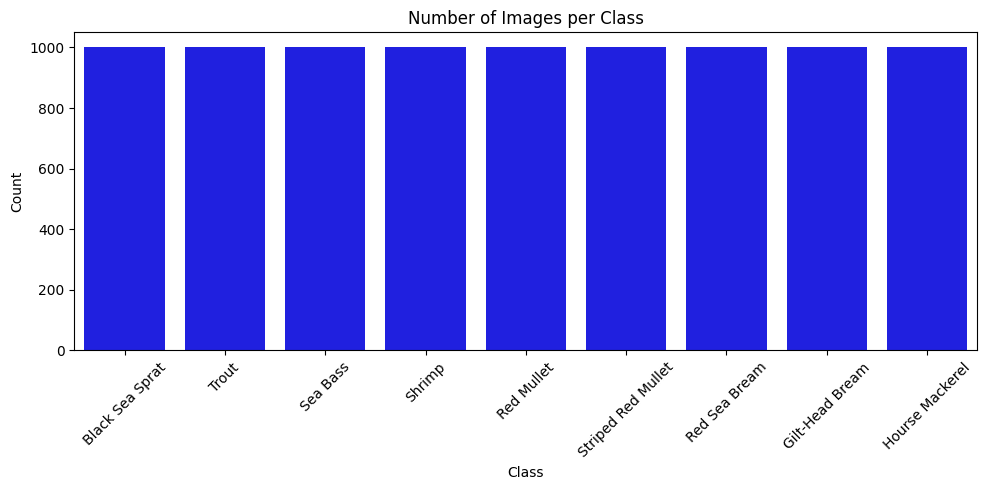

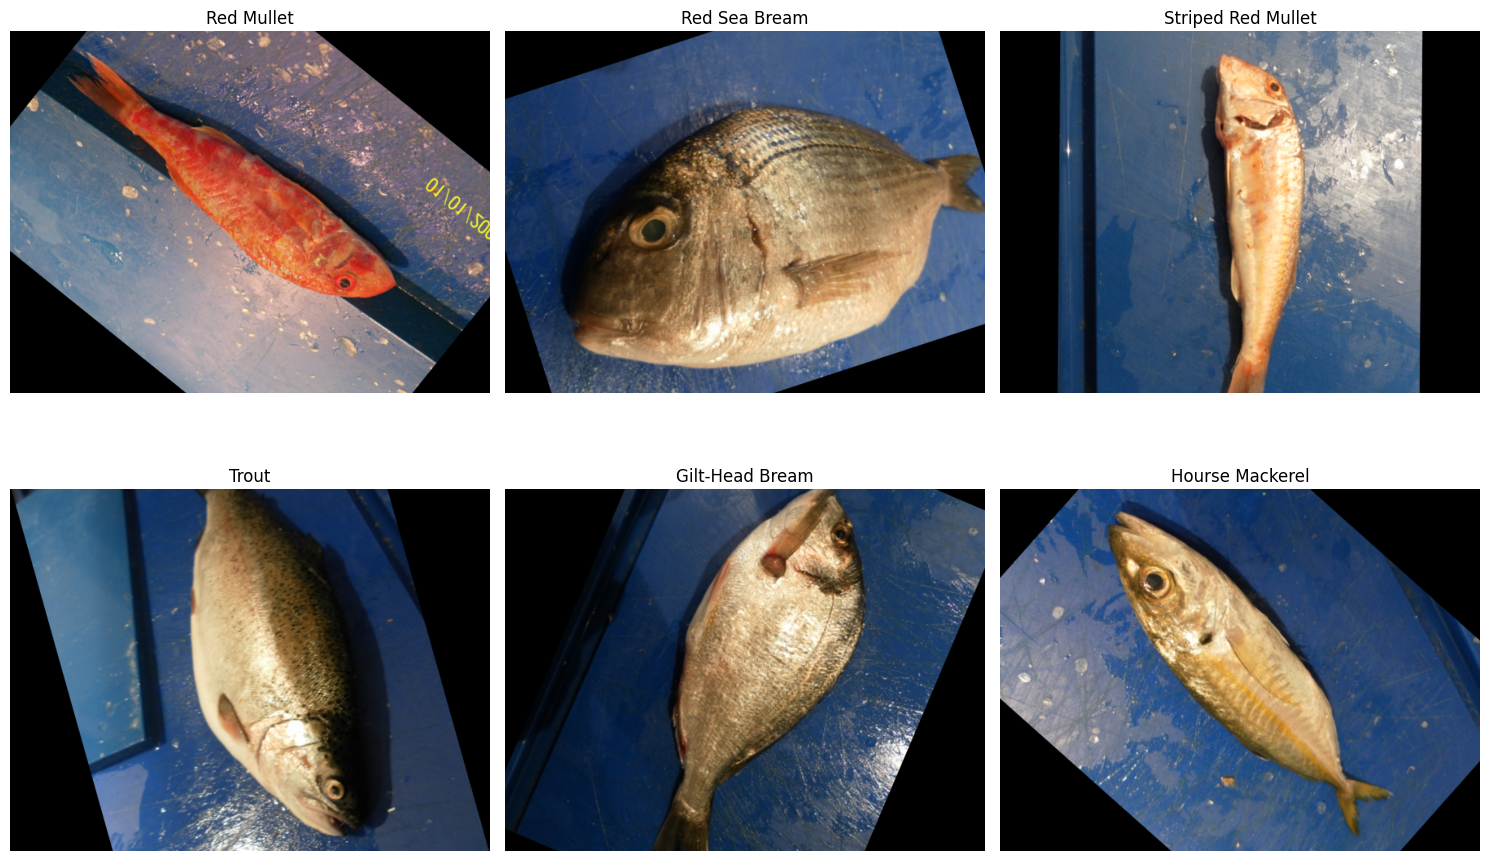

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import random

# Count the number of images per class
class_counts = df_img['labels'].value_counts().sort_values(ascending=False)
print("Class distribution:")
print(class_counts)

# Plot the class distribution
plt.figure(figsize=(10,5))
sns.barplot(x=class_counts.index, y=class_counts.values, color='blue')
plt.xticks(rotation=45)
plt.title("Number of Images per Class")
plt.ylabel("Count")
plt.xlabel("Class")
plt.tight_layout()
plt.show()


unique_classes = df_img['labels'].unique()
plt.figure(figsize=(15, 10))
sample_classes = np.random.choice(unique_classes, size=min(6, len(unique_classes)), replace=False)

for i, cls in enumerate(sample_classes):
    # Filter the df for this class
    cls_df = df_img[df_img['labels'] == cls]
    # Randomly select one image from this class
    img_path = cls_df['path'].sample(n=1).values[0]
    img = Image.open(img_path)

    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.tight_layout()
plt.show()

There is no missing data so we can move on.

# Data Splitting (Training & Validation Sets)

Before training, we need to divide our dataset into at least two sets:
*   Training Set: Used for model learning.
*   Validation Set: Used to tune model hyperparameters and prevent overfitting.

we will plit approximately 80% of the data for training and 20% for validation, although these ratios can be adjusted based on dataset size and complexity.

By shuffling the data first (which we already did during preprocessing), we ensure that our splits are random and unbiased.

In [7]:
from sklearn.model_selection import train_test_split

train_ratio = 0.8

train_df, val_df = train_test_split(df_img, test_size=(1-train_ratio), random_state=42, stratify=df_img['labels'])

print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))

Training set size: 7200
Validation set size: 1800


# Preparing the Data for Model Training

Now that we have our training and validation data separated, we need to prepare them for input into a deep learning model. Since we used a DataFrame-based approach, we have two main options:

1.   tf.data Pipeline:
Convert the filepaths and labels into a tf.data.Dataset. This approach is highly customizable and integrates smoothly with TensorFlow’s data augmentation, prefetching, and caching functionalities.

2.   Reorganize Files and Use flow_from_directory():
Move images into a directory structure where each class has its own folder, and then use Keras’ ImageDataGenerator with flow_from_directory(). However, this requires additional file operations.

For flexibility and reproducibility, we’ll demonstrate the tf.data approach. This allows us to load images directly from their filepaths and apply augmentations on the fly.

In [8]:
import tensorflow as tf

# Convert class labels to a numeric form if needed
class_names = sorted(df_img['labels'].unique())
class_to_index = {name: i for i, name in enumerate(class_names)}

def process_path(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)

    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize to a consistent shape
    img = tf.image.resize(img, [224, 224])
    return img, label

def df_to_dataset(dataframe, class_to_index, batch_size=32, shuffle=True):
    labels = dataframe['labels'].map(lambda x: class_to_index[x]).values
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)
    paths = tf.convert_to_tensor(dataframe['path'].values, dtype=tf.string)

    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe))

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Create training and validation datasets
batch_size = 32
train_ds = df_to_dataset(train_df, class_to_index, batch_size=batch_size, shuffle=True)
val_ds = df_to_dataset(val_df, class_to_index, batch_size=batch_size, shuffle=False)

# Check a batch shape
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Class indices in this batch:", labels.numpy())
    break


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
Class indices in this batch: [3 7 5 3 0 2 7 2 5 0 0 6 2 6 1 1 2 5 7 3 4 5 3 3 5 1 4 4 2 3 2 5]


# Model Architecture Selection & Compilation

We will use a pre-trained model for transfer learning. Transfer learning allows us to start training from a model that has already learned general image features from a large dataset (e.g., ImageNet). We will:



*   Use MobileNetV2 as our base.
*   Freeze the base model’s weights initially, and add a few custom dense layers on top.
*   Compile the model with adam optimizer, categorical_crossentropy loss and accuracy as a metric.

In [9]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# Number of classes
num_classes = len(class_names)

# Load base model without the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Add custom top layers
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)  # Add dropout to reduce overfitting
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = models.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 9)                   │          11,529 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,269,513 (8.66 MB)

 Trainable params: 11,529 (45.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Model Training

We will train the model on train_ds and validate on val_ds. We’ll also use EarlyStopping to prevent overfitting by stopping training if the validation loss doesn’t improve after a certain number of epochs. Additionally, ModelCheckpoint can save the best model weights for later use.

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 448s 2s/step - accuracy: 0.6954 - loss: 0.9875 - val_accuracy: 0.9889 - val_loss: 0.0913
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 487s 2s/step - accuracy: 0.9845 - loss: 0.0918 - val_accuracy: 0.9950 - val_loss: 0.0442
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - accuracy: 0.9951 - loss: 0.0449 - val_accuracy: 0.9967 - val_loss: 0.0316
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 423s 2s/step - accuracy: 0.9947 - loss: 0.0335 - val_accuracy: 0.9978 - val_loss: 0.0220
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 422s 2s/step - accuracy: 0.9979 - loss: 0.0228 - val_accuracy: 0.9983 - val_loss: 0.0180
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 508s 2s/step - accuracy: 0.9985 - loss: 0.0167 - val_accuracy: 0.9972 - val_loss: 0.0195
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 522s 2s/step - accuracy: 0.9986 - loss: 0.0135 - val_accuracy: 0.9983 - val_loss: 0.0126
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 511s 2s/step - accuracy: 0.9994 - loss: 0.0109 - val_accu

# Evaluate Model Performance

After training, we can evaluate the model on the validation set. We’ll examine the accuracy and also produce a confusion matrix and classification report for more granular insights into class-by-class performance.



**Training History analysis**

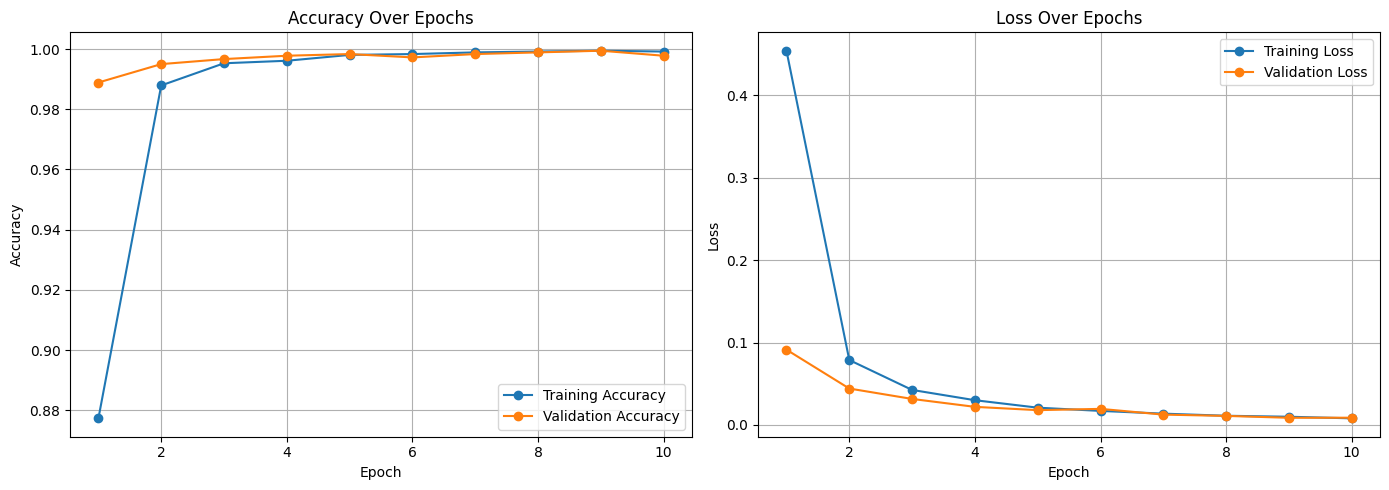

In [11]:
# Extract accuracy and loss history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))

# Plot accuracy
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


57/57 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9997 - loss: 0.0075
Validation Loss: 0.0087
Validation Accuracy: 0.9994
57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step


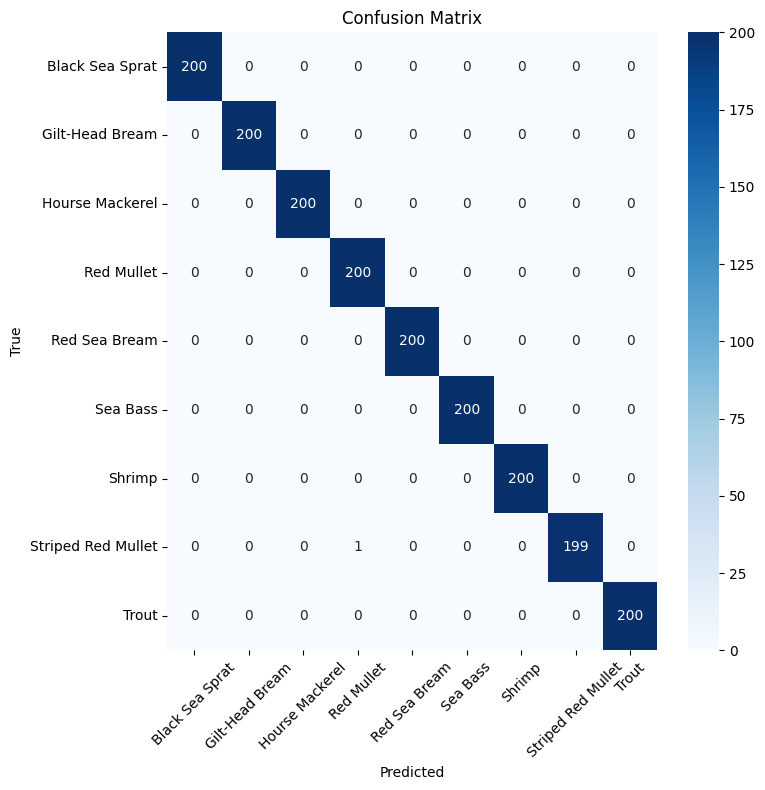

Classification Report:
                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       200
   Gilt-Head Bream       1.00      1.00      1.00       200
   Hourse Mackerel       1.00      1.00      1.00       200
        Red Mullet       1.00      1.00      1.00       200
     Red Sea Bream       1.00      1.00      1.00       200
          Sea Bass       1.00      1.00      1.00       200
            Shrimp       1.00      1.00      1.00       200
Striped Red Mullet       1.00      0.99      1.00       200
             Trout       1.00      1.00      1.00       200

          accuracy                           1.00      1800
         macro avg       1.00      1.00      1.00      1800
      weighted avg       1.00      1.00      1.00      1800



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Evaluate the model on the validation dataset to confirm final performance
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# Extract images and labels from the validation dataset
val_images_list = []
val_labels_list = []

for img_batch, label_batch in val_ds:
    val_images_list.append(img_batch)
    val_labels_list.append(label_batch)

val_images = tf.concat(val_images_list, axis=0)
val_labels = tf.concat(val_labels_list, axis=0)

# Predict on the entire validation set
pred_probs = model.predict(val_images)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = val_labels.numpy()

# Confusion Matrix
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_names))


**Summary:** The evaluation results demonstrate that the model achieves exceptionally high accuracy on the validation set, nearing perfect classification performance. This suggests that the chosen architecture, MobileNetV2, along with the effective preprocessing steps and ample, well-represented data, has successfully captured the distinguishing features of each fish species. The alignment between training and validation metrics indicates that the model has generalized well without overfitting, as both sets exhibit similarly high performance. Additionally, while the overall accuracy is outstanding, examining the confusion matrix and classification report reveals that only a minimal number of misclassifications occur within certain classes. These slight inaccuracies present opportunities for further enhancement, such as incorporating more samples for those specific classes, applying targeted data augmentations, or fine-tuning the model parameters to bolster its robustness.

**Conclusion:**
The model's near-perfect performance underscores the effectiveness of the transfer learning approach and the quality of the dataset used. To ensure the model's reliability in real-world applications, it is recommended to validate its performance on the Ground Truth (GT) dataset, implement additional data augmentation techniques, and consider fine-tuning the architecture further. These steps will help confirm the model's generalization capabilities and address any minor misclassifications, thereby enhancing its overall robustness and accuracy.






